# Named Entity Recognition

# Dataset AnEM:
### Description:
"Anatomical entities such as kidney, muscle and blood are central to much of biomedical scientific discourse, and the detection of mentions of anatomical entities is thus necessary for the automatic analysis of the structure of domain texts." "The corpus consists of 500 documents (over 90,000 words) selected randomly from citation abstracts and full-text papers with the aim of making the corpus representative of the entire available biomedical scientific literature. The corpus annotation covers mentions of both healthy and pathological anatomical entities and contains over 3,000 annotated mentions." http://www.nactem.ac.uk/anatomy/ Paper: http://www.nactem.ac.uk/anatomy/docs/ohta2012opendomain.pdf

### File Visualization:


In [47]:
import pandas as pd
from IPython.display import display_html

#Try to change this variable value
sentence_to_visualize = 0

with open("./BetterDataset/data.train", 'rb') as file_handle:
    file_content = file_handle.read().decode('utf-8').strip()
    annotated_sentences = file_content.split('\n\n')
    sentence = annotated_sentences[sentence_to_visualize]
    sentence = sentence.split()
    sentence = [sentence[i:i + 2] for i in range(0, len(sentence), 2)]
    cols=['Tokens','Entity']
    df2 = pd.DataFrame(sentence, columns=cols)
    df2_styler = df2.reset_index(drop=True).style.set_table_attributes("style='display:inline'").set_caption('Entities Distribution')
    display_html(df2_styler._repr_html_(), raw=True)

,Tokens,Entity
0,IL-2,B-DNA
1,gene,I-DNA
2,expression,O
3,and,O
4,NF-kappa,B-protein
5,B,I-protein
6,activation,O
7,through,O
8,CD28,B-protein
9,requires,O


### Visual Example:
![ola](Images/sentence.png)

### Dataset Statistics:

In [46]:
from IPython.display import display_html
import pandas as pd
import numpy as np

d = np.array([['Train', 71697, 2815], ['Test', 45939, 1882], ['All', 117636, 4697]])
cols=['Split', 'Tokens', 'Sentences']
df = pd.DataFrame(d, columns=cols)

d2 = np.array([['Anatomical_system', 51],['Cell', 776],['Cellular_component', 199],['Developing_anatomical_structure ', 39],
              ['Immaterial_anatomical_entity', 60],['Multi-tissue_structure', 639],['Organ', 381],
              ['Organism_subdivision', 162],['Organism_substance', 291],['Pathological_formation', 368],
              ['Tissue', 169],['No Entity', 112000]])
cols=['Token Entities:', 'Count']
df2 = pd.DataFrame(d2, columns=cols)

df1_styler = df.reset_index(drop=True).style.set_table_attributes("style='display:inline'").set_caption('Instances Distribution')
df2_styler = df2.reset_index(drop=True).style.set_table_attributes("style='display:inline'").set_caption('Entities Distribution')

display_html(df1_styler._repr_html_()+df2_styler._repr_html_(), raw=True)

        

Instances Distribution 
 
 
 Split 
 Tokens 
 Sentences 
 
 
 0 
 Train 
 71697 
 2815 
 
 1 
 Test 
 45939 
 1882 
 
 2 
 All 
 117636 
 4697 
 
 
 Entities Distribution 
 
 
 Token Entities: 
 Count 
 
 
 0 
 Anatomical_system 
 51 
 
 1 
 Cell 
 776 
 
 2 
 Cellular_component 
 199 
 
 3 
 Developing_anatomical_structure 
 39 
 
 4 
 Immaterial_anatomical_entity 
 60 
 
 5 
 Multi-tissue_structure 
 639 
 
 6 
 Organ 
 381 
 
 7 
 Organism_subdivision 
 162 
 
 8 
 Organism_substance 
 291 
 
 9 
 Pathological_formation 
 368 
 
 10 
 Tissue 
 169 
 
 11 
 No Entity 
 112000

# Task:1 Prepare the dataset for the model
### Read data from a ConLL file:

In [48]:
import os
def read_conll(filename_end):
    word_pos = 0
    pos_pos= None
    iob_pos = 3
    sep = '\t'
    IOB= 'IOB2'
    corpus_root="./BetterDataset"

    for root, dirs, files in os.walk(corpus_root):
        for filename in files:
            if filename.endswith(filename_end):
                with open(os.path.join(root, filename), 'rb') as file_handle:
                    try:
                        file_content = file_handle.read().decode('utf-8').strip()
                    except:
                        raise ValueError("Can't process!")
                    
                    annotated_sentences = file_content.split('\n\n')
                    for annotated_sentence in annotated_sentences:
                        annotated_tokens = [seq for seq in annotated_sentence.split('\n')]
                        all_tokens = []
                        #print(annotated_tokens)
                        for annotation in annotated_tokens:
                            conll_tokens = annotation.split(sep)
                            #print(conll_tokens)
                            all_tokens.append(conll_tokens)
                        yield all_tokens
                            
                            
data_train = list(read_conll('.train'))
data_test = list(read_conll('.test'))

#We can visualize the input for each sentence:
print(data_train[0])

[['IL-2', 'B-DNA'], ['gene', 'I-DNA'], ['expression', 'O'], ['and', 'O'], ['NF-kappa', 'B-protein'], ['B', 'I-protein'], ['activation', 'O'], ['through', 'O'], ['CD28', 'B-protein'], ['requires', 'O'], ['reactive', 'O'], ['oxygen', 'O'], ['production', 'O'], ['by', 'O'], ['5-lipoxygenase', 'B-protein'], ['.', 'O']]


### Merge sentence and label vectors:

In [53]:
def transform(data):
    sentences_array=[]
    labels_array=[]
    for data_input in data:
        sentence=[]
        labels=[]
        for vec in data_input:
            sentence.append(vec[0])
            labels.append(vec[1])
        sentences_array.append(sentence)
        labels_array.append(labels)

    return sentences_array,labels_array

sentences_train, labels_train = transform(data_train)
sentences_test, labels_test = transform(data_test)

#We can visualize the input for each sentence:
print(sentences_train[0])
print(labels_train[0])

['IL-2', 'gene', 'expression', 'and', 'NF-kappa', 'B', 'activation', 'through', 'CD28', 'requires', 'reactive', 'oxygen', 'production', 'by', '5-lipoxygenase', '.']
['B-DNA', 'I-DNA', 'O', 'O', 'B-protein', 'I-protein', 'O', 'O', 'B-protein', 'O', 'O', 'O', 'O', 'O', 'B-protein', 'O']


### Convert Labels to Numeric Values:

In [54]:
import numpy as np
def convert(labels_array):
    labels_array_changed = np.copy(labels_array)
    for idx,label_vec in enumerate(labels_array_changed):
        for idx,label in enumerate(label_vec):
            if label=="O":
                label_vec[idx]=0
            if label=="B-protein":
                label_vec[idx]=1
            if label=="I-protein":
                label_vec[idx]=2
            if label=="B-DNA":
                label_vec[idx]=3
            if label=="I-DNA":
                label_vec[idx]=4
            if label=="B-RNA":
                label_vec[idx]=5
            if label=="I-RNA":
                label_vec[idx]=6
            if label=="B-cell_type":
                label_vec[idx]=7
            if label=="I-cell_type":
                label_vec[idx]=8
            if label=="B-cell_line":
                label_vec[idx]=9
            if label=="I-cell_line":
                label_vec[idx]=10
    return labels_array_changed

labels_train_transformed = convert(labels_train)
labels_test_transformed = convert(labels_test)
print(labels_train_transformed.shape)
print(labels_test_transformed.shape)
print(labels_train_transformed[0])
print(labels_test_transformed[0])

(18546,)
(105,)
[3, 4, 0, 0, 1, 2, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]
[0, 0, 0, 0, 0, 0, 1, 2, 0, 1, 2, 2, 0, 1, 0, 0, 1, 0, 0, 0, 0, 7, 8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0]


### Optional to convert to one-hot encoding :

In [67]:
import keras
def to_categorical(labels_array):
    print(labels_array.shape)
    labels_train_changed = np.copy(labels_array)
    for idx,label_vec in enumerate(labels_train_changed):
        label_vec = keras.utils.to_categorical(label_vec, num_classes=11, dtype='float32')
        labels_train_changed[idx]=label_vec
    return labels_train_changed

print(labels_train_transformed[0])
example = to_categorical(labels_train_transformed)
print(example[0])

[3, 4, 0, 0, 1, 2, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]
(18546,)
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


### Visualize Reports length:

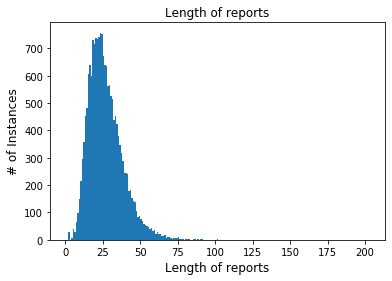

In [57]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.ticker import FuncFormatter
tlen = [len(x) for x in sentences_train] 
fig, ax = plt.subplots()
plt.hist(tlen, bins=np.arange(max(tlen)), histtype='barstacked', linewidth=2)
plt.title("Length of reports")
plt.ylabel('# of Instances', fontsize=12)
plt.xlabel('Length of reports', fontsize=12)
plt.show()

### Padding to Input Shape:

In [68]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np


tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences_train)
tokenizer.fit_on_texts(sentences_test)
voc_size = len(tokenizer.word_index)+1

def convert2(x,y):
    X_total = tokenizer.texts_to_sequences(x)
    X_total = pad_sequences(X_total, maxlen=50, padding='post')
    Y_total = pad_sequences(y, maxlen=50, padding='post', value=0)
    return X_total,Y_total

X_train, y_train = convert2(sentences_train, labels_train_transformed)
X_test, y_test = convert2(sentences_test, labels_test_transformed)

print("Input Shapes:")
print(X_train.shape)
print(X_test.shape)

print("Target Shapes:")
y_train = np.expand_dims(y_train, axis=2)
print(y_train.shape)
y_test = np.expand_dims(y_test, axis=2)
print(y_test.shape)

Input Shapes:
(18546, 50)
(105, 50)
Target Shapes:
(18546, 50, 1)
(105, 50, 1)


### Metric Evaluation:

In [61]:
from tensorflow.python.ops import math_ops
from tensorflow.python.framework import ops
from tensorflow.python.keras import backend as K
from tensorflow.python.ops import array_ops
def new_sparse_categorical_accuracy(y_true, y_pred):
        y_pred_rank = ops.convert_to_tensor(y_pred).get_shape().ndims
        y_true_rank = ops.convert_to_tensor(y_true).get_shape().ndims
        # If the shape of y_true is (num_samples, 1), squeeze to (num_samples,)
        if (y_true_rank is not None) and (y_pred_rank is not None) and (len(K.int_shape(y_true)) == len(K.int_shape(y_pred))):
            y_true = array_ops.squeeze(y_true, [-1])
        y_pred = math_ops.argmax(y_pred, axis=-1)
        # If the predicted output and actual output types don't match, force cast them
        # to match.
        if K.dtype(y_pred) != K.dtype(y_true):
            y_pred = math_ops.cast(y_pred, K.dtype(y_true))
        return math_ops.cast(math_ops.equal(y_true, y_pred), K.floatx())

# Attempt 1:
### Create Model:

In [69]:
from keras.models import Model
from keras.layers import Dense,TimeDistributed, Input, Embedding,Bidirectional,LSTM,Dropout
from sklearn.utils import class_weight
import numpy as np

def create_model(voc):
    sequence_input = Input(shape=(50,), dtype='int32')
    embedded_sequences = Embedding(voc, 32, input_length=50)(sequence_input)
    bilstm = Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True, return_state=False))(embedded_sequences)
    dense = Dense(256)(bilstm)
    drop = Dropout(0.2)(dense)
    preds = TimeDistributed(Dense(11, activation='softmax'))(drop)
    model = Model(inputs=sequence_input, outputs=preds)

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=[new_sparse_categorical_accuracy])
    model.summary()
    return model

model = create_model(voc_size)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 50, 32)            643520    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 50, 256)           164864    
_________________________________________________________________
dense_3 (Dense)              (None, 50, 256)           65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 256)           0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 50, 11)            2827      
Total params: 877,003
Trainable params: 877,003
Non-trainable params: 0
_________________________________________________________________


### Train:

In [70]:
from keras_tqdm import TQDMNotebookCallback
from sklearn_crfsuite import metrics

model.fit(x=X_train, y=y_train,validation_split=0.2,batch_size=32, epochs=3,verbose=0, callbacks=[TQDMNotebookCallback(leave_inner=True)])
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=-1)
y_pred = np.expand_dims(y_pred, axis=2)
print(metrics.flat_classification_report(y_test, y_pred, digits=3))



[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [2]
 [0]
 [1]
 [2]
 [2]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [7]
 [8]
 [8]
 [8]
 [8]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]
[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [2]
 [0]
 [1]
 [2]
 [2]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [7]
 [8]
 [8]
 [8]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]
              precision    recall  f1-score   support

           0      0.970     0.983     0.976      4770
           1      0.550     0.661     0.601       124
           2      0.775     0.457     0.575       151
           3      0.333     0.667     0.444         6
           4      0.391     1.000     0.562         9
           5      0.000     0.000     0.000        15
           6      0.750     0.231     0.353        26
           7      0.714     0.545     0.619        55
           

### Train2:

In [75]:
from sklearn_crfsuite import metrics
from sklearn.utils import class_weight
import numpy as np

def checkifAllOut(sentence):
    for output in sentence:
        if(output!=0):
            return True
    return False

def RemoveOnlyOtherSentences(x_train,y_train):
    x_train_final = []
    y_train_final = []
    for idx, sentence in enumerate(y_train):
        if(checkifAllOut(sentence)):
            x_train_final.append(x_train[idx])
            y_train_final.append(sentence)
    return np.array(x_train_final),np.array(y_train_final)

unique, counts = np.unique(y_train, return_counts=True)
print(unique)
print(counts)

X_train_new, y_train_new = RemoveOnlyOtherSentences(X_train,y_train)

unique, counts = np.unique(y_train_new, return_counts=True)
print(unique)
print(counts)

print(X_train_new.shape)
print(y_train_new.shape)

model.fit(x=X_train_new, y=y_train_new,validation_split=0.2,batch_size=64,
          epochs=3,verbose=0,
          callbacks=[TQDMNotebookCallback(leave_inner=True)])
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=-1)
y_pred = np.expand_dims(y_pred, axis=2)
print(metrics.flat_classification_report(y_test, y_pred, digits=3))


[ 0  1  2  3  4  5  6  7  8  9 10]
[819129  29916  24538   9399  15547    926   1493   6630   8645   3775
   7302]
[ 0  1  2  3  4  5  6  7  8  9 10]
[724279  29916  24538   9399  15547    926   1493   6630   8645   3775
   7302]
(16649, 50)
(16649, 50, 1)


              precision    recall  f1-score   support

           0      0.972     0.984     0.978      4770
           1      0.599     0.734     0.659       124
           2      0.847     0.477     0.610       151
           3      0.333     0.667     0.444         6
           4      0.360     1.000     0.529         9
           5      0.000     0.000     0.000        15
           6      0.833     0.192     0.312        26
           7      0.667     0.582     0.621        55
           8      0.793     0.535     0.639        86
           9      0.286     1.000     0.444         2
          10      0.250     0.833     0.385         6

    accuracy                          0.945      5250
   macro avg      0.540     0.637     0.511      5250
weighted avg      0.947     0.945     0.942      5250



In [76]:
from keras.models import Model
from keras.layers import Dense,TimeDistributed, Input, Embedding,Bidirectional,LSTM,Dropout
from keras_contrib.layers import CRF
from keras_contrib import losses, metrics
from sklearn.utils import class_weight
import numpy as np


def create_model(voc):
    sequence_input = Input(shape=(50,), dtype='int32')
    embedded_sequences = Embedding(voc,64, input_length=50)(sequence_input)
    bilstm = Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True, return_state=False))(embedded_sequences)
    dense = Dense(256)(bilstm)
    drop = Dropout(0.2)(dense)
    preds = TimeDistributed(Dense(64, activation='relu'))(drop)
    crf = CRF(11)
    out = crf(preds)
    model = Model(inputs=sequence_input, outputs=out)
    model.compile(optimizer="rmsprop", loss=losses.crf_loss, metrics=[metrics.crf_accuracy])
    model.summary()
    return model



model = create_model(voc_size)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 50, 64)            1287040   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 50, 256)           197632    
_________________________________________________________________
dense_5 (Dense)              (None, 50, 256)           65792     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50, 256)           0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 50, 64)            16448     
_________________________________________________________________
crf_1 (CRF)                  (None, 50, 11)            858       
Total para

In [79]:
y_train_input = np.squeeze(y_train_new, axis=2)
from keras.utils import to_categorical
from sklearn_crfsuite import metrics
# One-Hot encode
y = [to_categorical(i, num_classes=11) for i in y_train_new]  # n_tags+1(PAD)
y = np.array(y)
print(y.shape)

model.fit(x=X_train_new, y=y,validation_split=0.2,batch_size=64,
          epochs=3,verbose=0,
          callbacks=[TQDMNotebookCallback(leave_inner=True)])
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=-1)
y_pred = np.expand_dims(y_pred, axis=2)
print(metrics.flat_classification_report(y_test, y_pred, digits=3))

(16649, 50, 11)


              precision    recall  f1-score   support

           0      0.973     0.984     0.979      4770
           1      0.570     0.726     0.638       124
           2      0.852     0.457     0.595       151
           3      0.222     0.333     0.267         6
           4      0.375     1.000     0.545         9
           5      0.000     0.000     0.000        15
           6      0.778     0.269     0.400        26
           7      0.638     0.545     0.588        55
           8      0.733     0.512     0.603        86
           9      0.222     1.000     0.364         2
          10      0.240     1.000     0.387         6

    accuracy                          0.943      5250
   macro avg      0.509     0.621     0.488      5250
weighted avg      0.946     0.943     0.941      5250

